In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df1 = pd.read_csv("data/야수_전처리_ver12.csv")
df2 = pd.read_csv("data/2026_FA예정_타자.csv")

In [3]:
# 계약금 컬럼 생성
df1['FA 계약 총액'] = df1['FA 계약 총액'].fillna(0)
df1['연봉'] = df1['연봉'].fillna(0)
df1['계약금'] = df1['FA 계약 총액'] + df1['연봉']

In [4]:
# 전처리 함수 정의
def preprocess(df):
    df = df.copy()
    if '구분' in df.columns:
        df = df[~df['구분'].isin(['해외', 'FA 1년차'])]
    if 'FA등급' in df.columns:
        df = df[~df['FA등급'].isin(['해외', 'FA 1년차'])]
    if '플레이년도' in df.columns:
        df = df[df['플레이년도'] > 2015]

    drop_cols = ['선수명_수정', 'FA 계약 총액', '연봉', '잔류여부']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
    df = df.groupby('선수명', as_index=False).mean(numeric_only=True)
    return df

df1_cleaned = preprocess(df1)
df2_cleaned = preprocess(df2)

C:\Users\Lee\AppData\Local\Temp\ipykernel_7372\3216511609.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')


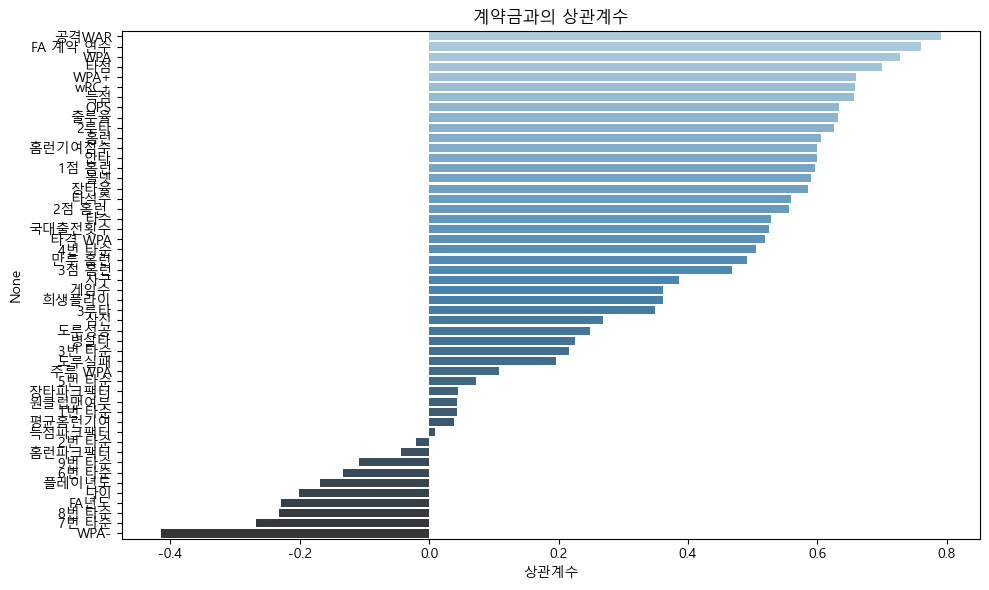

In [5]:
# 상관계수 및 가중치 계산
correlations = df1_cleaned.corr(numeric_only=True)['계약금'].drop('계약금').sort_values(ascending=False)
weights = correlations.abs() / correlations.abs().sum()
weight_df = pd.DataFrame({'컬럼명': weights.index, '가중치': weights.values})

# 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')
plt.title('계약금과의 상관계수')
plt.xlabel('상관계수')
plt.tight_layout()
plt.show()

In [6]:
# 예측에 사용할 피처 선택
predict_features = [f for f in weights.index if f in df1_cleaned.columns and f in df2_cleaned.columns]
X = df1_cleaned[predict_features]
y = df1_cleaned['계약금']
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy[predict_features]
y = Xy['계약금']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df2_cleaned[predict_features]

In [7]:
# Optuna로 하이퍼파라미터 튜닝 (XGBoost)
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300]),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist'
    }
    model = XGBRegressor(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    return -score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2025-08-06 15:10:55,856] A new study created in memory with name: no-name-a35ada6b-2fdf-4c9c-b866-87d19f253cfa
[I 2025-08-06 15:10:56,478] Trial 0 finished with value: 108717.60190557115 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.25559280300601767, 'subsample': 0.9617146652331681, 'colsample_bytree': 0.7929835359095827, 'gamma': 0.7947599969496727, 'min_child_weight': 9, 'reg_alpha': 1.1860388136415119, 'reg_lambda': 1.6508713492273819}. Best is trial 0 with value: 108717.60190557115.
[I 2025-08-06 15:10:57,097] Trial 1 finished with value: 103391.29227007437 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1973365361383051, 'subsample': 0.8729438512423401, 'colsample_bytree': 0.6196415250739662, 'gamma': 1.1350502437467718, 'min_child_weight': 2, 'reg_alpha': 1.1430977791312336, 'reg_lambda': 2.234890989583627}. Best is trial 1 with value: 103391.29227007437.
[I 2025-08-06 15:10:57,347] Trial 2 finished with value: 104237.82341

In [8]:
# 최적 모델 학습 및 검증
best_params = study.best_params
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

print("[XGBoost + Optuna] 최적 파라미터:")
print(best_params)

val_pred = best_model.predict(X_val)

mse = mean_squared_error(y_val, val_pred) 
rmse = mean_squared_error(y_val, val_pred, squared=False)
mae = mean_absolute_error(y_val, val_pred)
r2 = r2_score(y_val, val_pred)

print(f"[모델 평가 지표]")
print(f" MSE : {mse:,.2f}")
print(f" RMSE: {rmse:,.2f}")
print(f" MAE : {mae:,.2f}")
print(f" R²  : {r2:.4f}")

[XGBoost + Optuna] 최적 파라미터:
{'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.19950090389878178, 'subsample': 0.8620695580052884, 'colsample_bytree': 0.6180827809243176, 'gamma': 1.232661249919317, 'min_child_weight': 2, 'reg_alpha': 1.7907132637715684, 'reg_lambda': 2.1916254345585977}
[모델 평가 지표]
 MSE : 16,567,098,615.09
 RMSE: 128,713.24
 MAE : 78,721.61
 R²  : 0.6759


C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [9]:
# 계약금 예측 및 반올림
df2_cleaned['계약금'] = best_model.predict(X_test).round(0).astype(int)

C:\Users\Lee\AppData\Local\Temp\ipykernel_7372\2933799307.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y='컬럼명', x='중요도 (XGBoost)', palette='YlGnBu')


피처 중요도 (XGBoost + Optuna):
       컬럼명  중요도 (XGBoost)  상관계수 기반 가중치
17  국대출전횟수       0.247632     0.027093
0    공격WAR       0.134284     0.040855
5       득점       0.083210     0.033944
42      나이       0.078501     0.010384
4     wRC+       0.059560     0.033973
1      WPA       0.045496     0.037568
8      2루타       0.031938     0.032353
31  주루 WPA       0.029965     0.005569
3     WPA+       0.025801     0.034056
2       타점       0.025102     0.036160
30    도루실패       0.024034     0.010136
27    도루성공       0.020038     0.012825
12   1점 홈런       0.019643     0.030799
45   7번 타순       0.016847     0.013771
7      출루율       0.016621     0.032661
11      안타       0.011622     0.030939
18  타격 WPA       0.011506     0.026799
25     3루타       0.010068     0.018032
22      사구       0.009922     0.019909
13      볼넷       0.008697     0.030449
36  득점파크팩터       0.008651     0.000481
33  장타파크팩터       0.008210     0.002330
20   만루 홈런       0.007019     0.025381
6      OPS       0.006645     0.03273

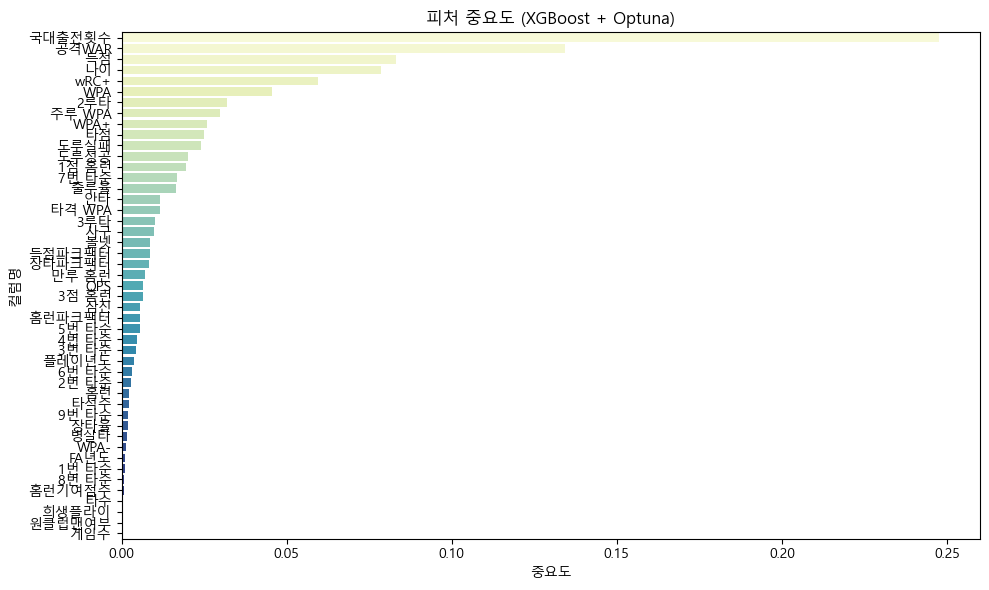

In [10]:
# 피처 중요도 분석
importance_df = pd.DataFrame({
    '컬럼명': predict_features,
    '중요도 (XGBoost)': best_model.feature_importances_,
    '상관계수 기반 가중치': [weights[f] for f in predict_features]
}).sort_values(by='중요도 (XGBoost)', ascending=False)

print("피처 중요도 (XGBoost + Optuna):")
print(importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, y='컬럼명', x='중요도 (XGBoost)', palette='YlGnBu')
plt.title('피처 중요도 (XGBoost + Optuna)')
plt.xlabel('중요도')
plt.tight_layout()
plt.show()

In [11]:
# 예측 결과 출력
print("예측 계약금 상위 선수 (XGBoost + Optuna):")
print(df2_cleaned[['선수명', '계약금']].sort_values(by='선수명', ascending=True))

예측 계약금 상위 선수 (XGBoost + Optuna):
    선수명     계약금
0   강민호  236602
1   강백호   97913
2   김재환  196657
3   박병호  173335
4   박승욱   30579
5   박찬호  126044
6   박해민  180238
7   손아섭  153364
8   이재원   51343
9   장성우  154732
10   정훈   47523
11  조수행   19771
12  최원준  129277
13  최형우  223949
14  황재균  109924
